In [1]:
import numpy as np
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

# plt.style.use(dufte.style)
# plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle')
plt.style.use("science")
plt.style.use("notebook")


def weighted_dates2series(
    participants: np.ndarray,
    dates: np.ndarray,
    start=None,
    end=None,
) -> pd.Series:
    start = start or min(dates)
    end = end or max(dates)
    index = [
        start + i * datetime.timedelta(days=1) for i in range((end - start).days + 1)
    ]
    # terribly inefficient
    values = np.array([participants[dates <= ind].sum() for ind in index])
    assert values.max() == participants.sum()
    return pd.Series(values, index=index)

In [2]:
def get_date_series(df: pd.DataFrame, **kwargs) -> pd.Series:
    return weighted_dates2series(df["Registrations"], df["Start date"], **kwargs)

In [3]:
COLOR = "black"
matplotlib.rcParams["text.color"] = COLOR
matplotlib.rcParams["axes.labelcolor"] = COLOR
matplotlib.rcParams["xtick.color"] = COLOR
matplotlib.rcParams["ytick.color"] = COLOR

In [20]:
from pathlib import Path

data_dir = Path(".").resolve().parent / "data"
df = pd.read_csv(data_dir / "event-data - Sheet1.csv")
df["Start date"] = pd.to_datetime(df["Start date"], format="mixed")
df["co-organized"].fillna("", inplace=True)
no_collab = df.query("`co-organized` == ''").copy()

In [22]:
start = df["Start date"].min()
end = df["Start date"].max()

In [23]:
label2data = {
    "Teaching": get_date_series(
        no_collab.query("type == 'teach'"), start=start, end=end
    ),
    "Co-teaching": get_date_series(
        df.query("`co-organized` != '' & type == 'teach'"), start=start, end=end
    ),
    "Outreach": get_date_series(
        no_collab.query("type == 'outreach'"), start=start, end=end
    ),
    "Internal events": get_date_series(
        no_collab.query("type != ['teach','outreach']"), start=start, end=end
    ),
}

accounted_for = [v.max() for v in label2data.values()]
assert sum(accounted_for) == df["Registrations"].sum(), (
    accounted_for,
    sum(accounted_for),
    df["Registrations"].sum(),
)

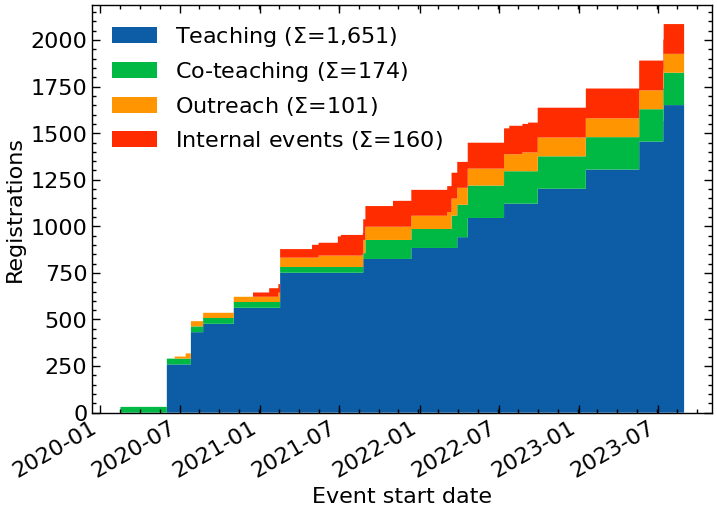

In [24]:
# ax = get_date_series(df).plot(label="Total", lw=3)
fig, ax = plt.subplots()
baseline = None
for key, value in label2data.items():
    if baseline is None:
        baseline = np.zeros_like(value)
    label = f"{key} ($\Sigma$={int(value.max()):,})"
    ax.stairs(
        value.to_numpy() + baseline,
        [*value.index, datetime.datetime.now()],
        baseline=baseline,
        label=label,
        fill=True,
    )
    baseline += value
ax.legend(loc="upper left", frameon=False)
ax.set_ylabel("Registrations")
ax.set_xlabel("Event start date")

import matplotlib.dates as mdates

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
fig.autofmt_xdate()

In [25]:
get_date_series(df).to_csv(data_dir / "total_participants_events.csv")

In [26]:
df["Registrations"].sum()

2086.0

Text(0, 0.5, 'Participants')

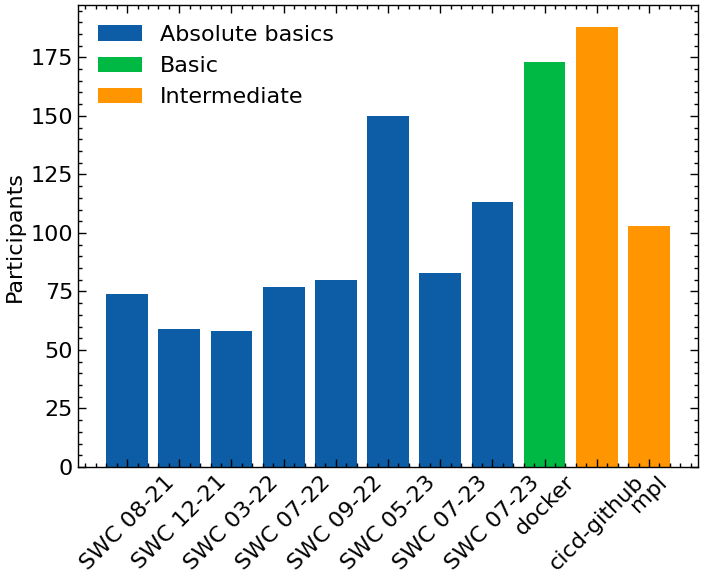

In [27]:
_, ax = plt.subplots()
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
ys = []
xs = []
swcs = df.query("type == 'teach' & Category == 'SWC'")
ys.extend(swcs["Registrations"].to_list())
xs.extend([f"SWC {d:%m-%y}" for d in swcs["Start date"]])
singles = df.query("type == 'teach' & Category == 'single-module'")
ys.extend(singles["Registrations"])
xs.extend(singles["Topics (comma-separated)"])
ax.set_xticks(list(range(len(xs))))
ax.set_xticklabels(xs, rotation=45)

ax.bar(list(range(len(xs)))[:-3], ys[:-3], label="Absolute basics")
ax.bar(list(range(len(xs)))[-3], ys[-3], color=colors[1], label="Basic")
ax.bar(list(range(len(xs)))[-2:], ys[-2:], color=colors[2], label="Intermediate")
ax.legend()
ax.set_ylabel("Participants")